# Image Segmentation for Ceramic Grains

## Data Preparation

We are going to retrieve our dataset images (4 training and 1 validation) and convert them to a gray-scale pixel matrix. We will assume that all input images are in gray-scale as this is a proof of concept and can easily be transferred to multiple color panes.

We are going to transform the input images to 1600 x 1600 pixels to make it square while not losing any grain boundary data as the boundary can be quite thin sometimes. We will downsample this with max-pooling later on in our CNN.

Then we will perform data augmentations to produce more samples (positional augmentation, color/hue augmentations, etc.).

In [43]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from typing import Tuple, Dict, List
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import JaccardIndex
from torchsummary import summary
import copy
import time

In [366]:
orig_res = (1600, 1200)
data_res = (256, 256)

to_image_tensor = T.ToImage()
resize_to_square = T.Resize(size=data_res, interpolation=T.InterpolationMode.NEAREST_EXACT, antialias=False)
to_grayscale = T.Grayscale(num_output_channels=1)
normalize_scale = T.ToDtype(torch.float32, scale=True)
resize_up_to_square = T.Resize(size=data_res, interpolation=T.InterpolationMode.NEAREST_EXACT, antialias=False)

prepare_img_transform = T.Compose([
  to_image_tensor,
  resize_to_square,
  to_grayscale,
  normalize_scale
])

prepare_seg_transform = T.Compose([
  to_image_tensor,
  to_grayscale,
  normalize_scale,
  nn.MaxPool2d(2),
  nn.MaxPool2d(2),
  nn.MaxPool2d(2),
  nn.MaxPool2d(2),
  resize_up_to_square,
  torch.ceil
])

expand_scale = T.ToDtype(torch.uint8, scale=True)
resize_to_original = T.Resize(size=orig_res, interpolation=T.InterpolationMode.NEAREST_EXACT, antialias=False)
to_pil_image = T.ToPILImage(mode='L')

output_transform = T.Compose([
  expand_scale,
  resize_to_original,
  to_pil_image
])

iou_fn = JaccardIndex(task='binary')

In [367]:
train_path = './grain_segmentation_data/train/'
train_x, train_y = [], []
for i in range(4):
  img = prepare_img_transform(Image.open(f'{train_path}/Images/{i}.png'))
  seg = prepare_seg_transform(Image.open(f'{train_path}/Segmentations/{i}.png'))
  train_x.append(img)
  train_y.append(seg)


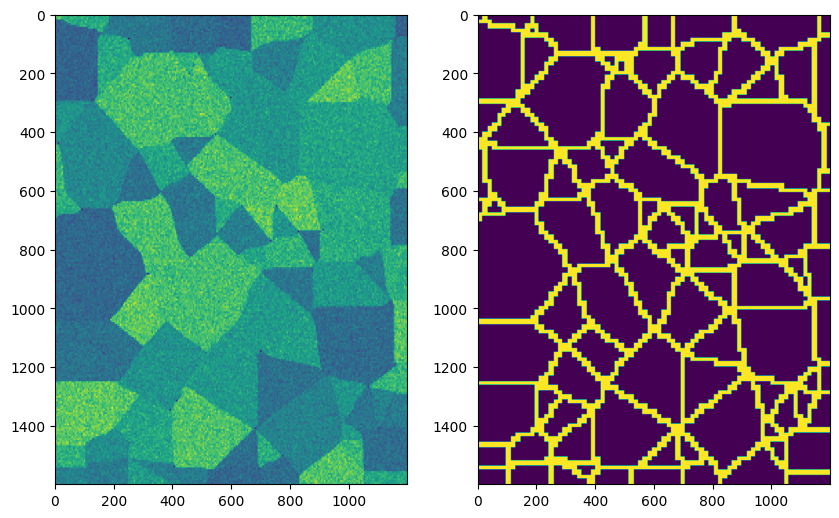

In [368]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
i = 1
ax1.imshow(output_transform(train_x[i]))
ax2.imshow(output_transform(train_y[i]))

In [369]:
aug_transform = T.Compose([
  T.ColorJitter(brightness=0.4, hue=0.3, saturation=0.2, contrast=0.3),
  T.GaussianBlur(kernel_size=(9, 9), sigma=(0.1, 3)),
  T.RandomAdjustSharpness(sharpness_factor=2),
  T.RandomAutocontrast(),
  # T.RandomRotation(degrees=(-180, 180), expand=True),
  # T.RandomResizedCrop(size=data_res, scale=(0.7, 1)),
  # T.Grayscale()
])

In [384]:
class CustomImageDataset(Dataset):
  def __init__(self, dir: str, img_transform=None, seg_transform=None, aug_transform=None) -> None:
    self.img_paths = list((Path(dir) / 'Images').glob("*.png"))
    self.seg_paths = list((Path(dir) / 'Segmentations').glob("*.png"))

    assert len(self.img_paths) == len(self.seg_paths)

    self.img_transform = img_transform
    self.seg_transform = seg_transform
    self.aug_transform = aug_transform
  
  def __len__(self) -> int:
    return len(self.img_paths) * 20

  def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
    i = idx % len(self.img_paths)

    # print(idx, i, self.img_paths, self.seg_paths)

    img = Image.open(self.img_paths[i])
    seg = Image.open(self.seg_paths[i])

    if self.img_transform:
      img = self.img_transform(img)
    if self.seg_transform:
      seg = self.seg_transform(seg)

    if self.aug_transform and idx >= 4:
      img = self.aug_transform(img)

    return img, seg

In [385]:
train_data = CustomImageDataset(dir='./grain_segmentation_data/train/', img_transform=prepare_img_transform, seg_transform=prepare_seg_transform, aug_transform=aug_transform)
val_data = CustomImageDataset(dir='./grain_segmentation_data/validation/', img_transform=prepare_img_transform, seg_transform=prepare_seg_transform, aug_transform=aug_transform)

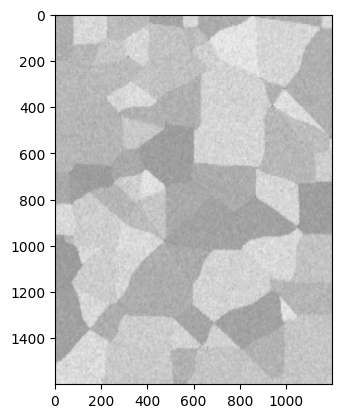

In [388]:
plt.imshow(output_transform(train_data[12][0]), cmap='gray', vmin=0, vmax=255)

In [389]:
train_dataloader = DataLoader(dataset=train_data, batch_size=1, num_workers=0, shuffle=True)
val_dataloader = DataLoader(dataset=val_data, batch_size=1, num_workers=0, shuffle=False)

dataloaders = {
  'train': train_dataloader,
  'val': val_dataloader
}

## Model

In [7]:
class DoubleConvolution(nn.Module):
  def __init__(self, in_channels: int, out_channels: int) -> None:
    super().__init__()
    
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
    self.act1 = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3)
    self.act2 = nn.ReLU()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv1(x)
    x = self.act1(x)
    x = self.conv2(x)
    x = self.act2(x)
    return x

In [8]:
class DownSample(nn.Module):
  def __init__(self) -> None:
    super().__init__()

    self.pool = nn.MaxPool2d(2)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.pool(x)
    return x

In [9]:
class UpSample(nn.Module):
  def __init__(self, in_channels: int, out_channels: int) -> None:
    super().__init__()

    self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.upconv(x)
    return x

In [10]:
class CropAndConcat(nn.Module):
  def forward(self, x: torch.Tensor, skip_x: torch.Tensor) -> torch.Tensor():

    skip_x = F.center_crop(skip_x, [x.shape[2], x.shape[3]])
    x = torch.cat([x, skip_x], dim=1)
    return x

In [300]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, mult: int) -> None:
    super().__init__()

    # self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in [(in_channels, mult), (mult, mult * 2), (mult * 2, mult * 4), (mult * 4, mult * 8)]])
    # self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])
    # self.middle_conv = DoubleConvolution(mult * 8, mult * 16)
    # self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in [(mult * 16, mult * 8), (mult * 8, mult * 4), (mult * 4, mult * 2), (mult * 2, mult)]])
    # self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in [(mult * 16, mult * 8), (mult * 8, mult * 4), (mult * 4, mult * 2), (mult * 2, mult)]])
    # self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
    # self.final_conv = nn.Conv2d(mult, out_channels, kernel_size=1)
    # self.final_up_sample = nn.Upsample(size=data_res)

    self.dconv_down1 = double_conv(1, 64)
    self.dconv_down2 = double_conv(64, 128)
    self.dconv_down3 = double_conv(128, 256)
    self.dconv_down4 = double_conv(256, 512)        

    self.maxpool = nn.MaxPool2d(2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
    
    self.dconv_up3 = double_conv(256 + 512, 256)
    self.dconv_up2 = double_conv(128 + 256, 128)
    self.dconv_up1 = double_conv(128 + 64, 64)
    
    self.conv_last = nn.Conv2d(64, 1, kernel_size=1)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # skips = []
    # for i in range(len(self.down_conv)):
    #   x = self.down_conv[i](x)
    #   skips.append(x)
    #   x = self.down_sample[i](x)

    # x = self.middle_conv(x)

    # for i in range(len(self.up_conv)):
    #   x = self.up_sample[i](x)
    #   x = self.concat[i](x, skips.pop())
    #   x = self.up_conv[i](x)
      
    # x = self.final_conv(x)
    # x = self.final_up_sample(x)

    conv1 = self.dconv_down1(x)
    x = self.maxpool(conv1)

    conv2 = self.dconv_down2(x)
    x = self.maxpool(conv2)
    
    conv3 = self.dconv_down3(x)
    x = self.maxpool(conv3)   
    
    x = self.dconv_down4(x)
    
    x = self.upsample(x)        
    x = torch.cat([x, conv3], dim=1)
    
    x = self.dconv_up3(x)
    x = self.upsample(x)        
    x = torch.cat([x, conv2], dim=1)       

    x = self.dconv_up2(x)
    x = self.upsample(x)        
    x = torch.cat([x, conv1], dim=1)   
    
    x = self.dconv_up1(x)
    
    x = self.conv_last(x)

    return x
    

In [301]:
model = UNet(1, 1, 64)
summary(model, (1, data_res[0], data_res[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]             640
              ReLU-2         [-1, 64, 400, 400]               0
            Conv2d-3         [-1, 64, 400, 400]          36,928
              ReLU-4         [-1, 64, 400, 400]               0
         MaxPool2d-5         [-1, 64, 200, 200]               0
            Conv2d-6        [-1, 128, 200, 200]          73,856
              ReLU-7        [-1, 128, 200, 200]               0
            Conv2d-8        [-1, 128, 200, 200]         147,584
              ReLU-9        [-1, 128, 200, 200]               0
        MaxPool2d-10        [-1, 128, 100, 100]               0
           Conv2d-11        [-1, 256, 100, 100]         295,168
             ReLU-12        [-1, 256, 100, 100]               0
           Conv2d-13        [-1, 256, 100, 100]         590,080
             ReLU-14        [-1, 256, 1

0 0 [PosixPath('grain_segmentation_data/train/Images/2.png'), PosixPath('grain_segmentation_data/train/Images/3.png'), PosixPath('grain_segmentation_data/train/Images/1.png'), PosixPath('grain_segmentation_data/train/Images/0.png')] [PosixPath('grain_segmentation_data/train/Segmentations/2.png'), PosixPath('grain_segmentation_data/train/Segmentations/3.png'), PosixPath('grain_segmentation_data/train/Segmentations/1.png'), PosixPath('grain_segmentation_data/train/Segmentations/0.png')]


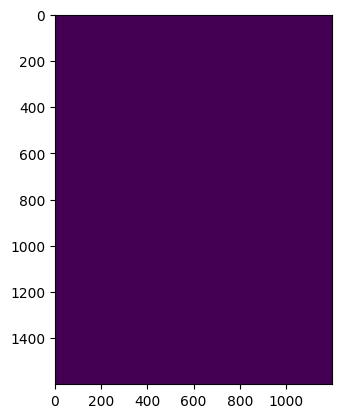

In [339]:
output_mask = nn.functional.sigmoid(model(train_data[0][0].view(1, 1, data_res[0], data_res[1])))
plt.imshow(output_transform(output_mask[0].round()))

In [390]:
def train_model(model, optimizer, loss_fn, scheduler, num_epochs=10):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 1e10

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    since = time.time()

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        scheduler.step()
        for param_group in optimizer.param_groups:
          print("LR", param_group['lr'])

        model.train()  # Set model to training mode
      else:
        model.eval()  # Set model to evaluate mode

      epoch_samples = 0

      for inputs, labels in dataloaders[phase]:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          iou = iou_fn(nn.functional.sigmoid(outputs), labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        epoch_samples += inputs.size(0)

      print(f'{phase}: loss = {loss}, iou = {iou}, epoch_samples = {epoch_samples}')
      epoch_loss = loss / epoch_samples

      # deep copy the model
      if phase == 'val' and epoch_loss < best_loss:
        print("saving best model")
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  print('Best val loss: {:4f}'.format(best_loss))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [400]:
# model = UNet(1, 1, 64)
# for p in model.parameters():
#   nn.init.normal_(p, mean=0, std=0.05)

model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="swsl",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

learning_rate = 1e-4
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# loss_fn = nn.functional.binary_cross_entropy_with_logits

def loss_fn(pred, target, bce_weight=0.5, smooth=1.):
  bce_loss = nn.functional.binary_cross_entropy_with_logits(pred, target)

  pred = torch.sigmoid(pred)
  pred = pred.contiguous()
  target = target.contiguous()

  intersection = (pred * target).sum(dim=2).sum(dim=2)

  # loss = -intersection / union
  dice_loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))).mean()

  loss = bce_loss * bce_weight + dice_loss * (1 - bce_weight)

  return loss

scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)

num_epochs = 20

train_model(model, optimizer, loss_fn, scheduler, num_epochs)

Downloading: "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnet50-16a12f1b.pth" to /Users/balaramdb/.cache/torch/hub/checkpoints/semi_weakly_supervised_resnet50-16a12f1b.pth
100.0%


Epoch 0/19
----------
LR 0.0001
train: loss = 0.4049459397792816, iou = 0.589848518371582, epoch_samples = 80
val: loss = 0.4992889165878296, iou = 0.44271737337112427, epoch_samples = 20
saving best model
1m 54s
Epoch 1/19
----------
LR 0.0001
train: loss = 0.3105524480342865, iou = 0.6862226128578186, epoch_samples = 80
val: loss = 0.40246739983558655, iou = 0.5093265175819397, epoch_samples = 20
saving best model
2m 4s
Epoch 2/19
----------
LR 0.0001
train: loss = 0.20476073026657104, iou = 0.8074951767921448, epoch_samples = 80
val: loss = 0.48772478103637695, iou = 0.3517276346683502, epoch_samples = 20
2m 25s
Epoch 3/19
----------
LR 0.0001
train: loss = 0.184466153383255, iou = 0.8190945386886597, epoch_samples = 80
val: loss = 0.4046831727027893, iou = 0.45126891136169434, epoch_samples = 20
2m 15s
Epoch 4/19
----------
LR 0.0001
train: loss = 0.13425955176353455, iou = 0.8790536522865295, epoch_samples = 80
val: loss = 0.3735283613204956, iou = 0.5135681629180908, epoch_sample

KeyboardInterrupt: 

In [401]:
output_mask = torch.sigmoid(model(train_data[0][0].view(1, 1, 256, 256)))
(output_mask > 0.5).sum()

tensor(15236)

tensor(10320)


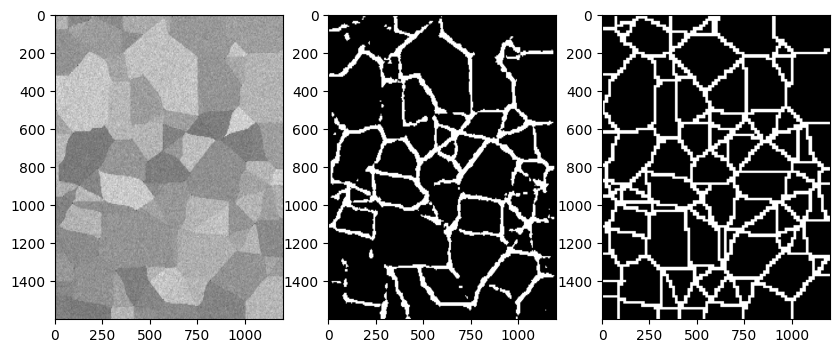

In [402]:
model.eval()
with torch.no_grad():
  for inputs, labels in dataloaders['val']:
    preds = model(inputs)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,10))
    ax1.imshow(output_transform(inputs[0]), cmap='gray', vmin=0, vmax=255)
    ax2.imshow(output_transform(torch.sigmoid(preds[0]).round()), cmap='gray', vmin=0, vmax=255)
    ax3.imshow(output_transform(labels[0]), cmap='gray', vmin=0, vmax=255)
    # output_transform(inputs[0]).show()
    # output_transform(torch.sigmoid(preds[0]).round()).show()
    # output_transform(labels[0]).show()

    print((torch.sigmoid(preds[0]) >= 0.5).sum())
    break

In [376]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [377]:
summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,